# **<font color='crimson'>SQL. Building Dashboards</font>**

---

In [ ]:
--DAU (Daily Active Users)
SELECT
    t.time::DATE AS date
    ,COUNT(DISTINCT t.user_id) AS DAU
FROM
    user_actions AS t
GROUP BY
    t.time::DATE;

In [ ]:
--WAU (Week Active Users)
SELECT
    DATE_TRUNC('week', t.time) AS week
    ,COUNT(DISTINCT t.user_id) AS WAU
FROM
    user_actions AS t
GROUP BY
    DATE_TRUNC('week', t.time);

In [ ]:
--MAU (Month Active Users)
SELECT
    DATE_TRUNC('month', t.time) AS month
    ,COUNT(DISTINCT t.user_id) AS MAU
FROM
    user_actions AS t
GROUP BY
    DATE_TRUNC('month', t.time);

In [ ]:
--вычислим количество активных курьеров
--(совершивших любое действие)
--и количество доставленных заказов
SELECT
    COUNT(DISTINCT t.courier_id) AS active_couriers
    ,time::DATE AS date
FROM
    courier_actions AS t
GROUP BY
    time::DATE;

Расчитаем ключевые метрики успешности продукта.

In [ ]:
--посчитаем количество отмененных заказов,
--созданных заказов и
--количество уникальных пользователей
WITH subquery AS (
    SELECT
        COUNT(t.order_id) FILTER (
            WHERE t.action = 'cancel_order')
            AS cancel_orders
        ,COUNT(t.order_id) FILTER (
            WHERE t.action = 'create_order')
            AS create_orders
        ,COUNT(DISTINCT t.user_id)
            AS active_users
        ,t.time::DATE AS date
    FROM
        user_actions AS t
    GROUP BY
        t.time::DATE
)
--дополнительно к показателям, отобранным в подзапросе,
--рассчитаем долю отмененных заказов,
--среднее количество заказов на одного клиента
SELECT
    t.cancel_orders * 1. / t.create_orders AS cancel_rate
    ,t.create_orders * 1. / t.active_users AS orders_per_user
    ,t.cancel_orders
    ,t.create_orders
    ,t.active_users
    ,t.date
FROM
    subquery AS t

In [ ]:
###

In [ ]:
--1
--определим самую раннюю дату действия каждого пользователя
--из таблицы user_actions
WITH user_first_action AS (
    SELECT
        DATE_TRUNC('day', t.time) AS date
        ,t.user_id
        ,MIN(DATE_TRUNC('day', t.time))
            OVER (PARTITION BY t.user_id) AS start_user_day
    FROM
        user_actions AS t
),
--вычислим количество новых пользователей за каждый день
new_users AS (
    SELECT
        t.start_user_day AS date
        ,COUNT(DISTINCT t.user_id) AS new_users
    FROM
        user_first_action AS t
    GROUP BY
        t.start_user_day
    ORDER BY
        t.start_user_day ASC
    ),
--определим самую раннюю дату действия каждого курьера
--из таблицы courier_actions
courier_first_action AS (
    SELECT
        DATE_TRUNC('day', t.time) AS date
        ,t.courier_id
        ,MIN(DATE_TRUNC('day', t.time))
            OVER (PARTITION BY t.courier_id) AS start_courier_day
    FROM
        courier_actions AS t
),
--вычислим количество новых курьеров за каждый день
new_couriers AS (
    SELECT
        t.start_courier_day AS date
        ,COUNT(DISTINCT t.courier_id) AS new_couriers
    FROM
        courier_first_action AS t
    GROUP BY
        t.start_courier_day
    ORDER BY
        t.start_courier_day ASC
),
--объединяем в одну таблицу сведения о новых клиентах
--и новых курьерах за каждый день
new_users_couriers AS (
    SELECT
        t.date
        ,t.new_users
        ,c.new_couriers
    FROM
        new_users AS t
        LEFT JOIN new_couriers AS c
            ON t.date = c.date
)
--рассчитаем общее число пользователей и курьеров
--на каждый день
SELECT
    t.date::DATE
    ,t.new_users
    ,t.new_couriers
    ,(SUM(t.new_users) OVER w)::INT AS total_users
    ,(SUM(t.new_couriers) OVER w)::INT AS total_couriers
FROM
    new_users_couriers AS t
WINDOW w AS (
    ORDER BY t.date
)
ORDER BY
    t.date::DATE;

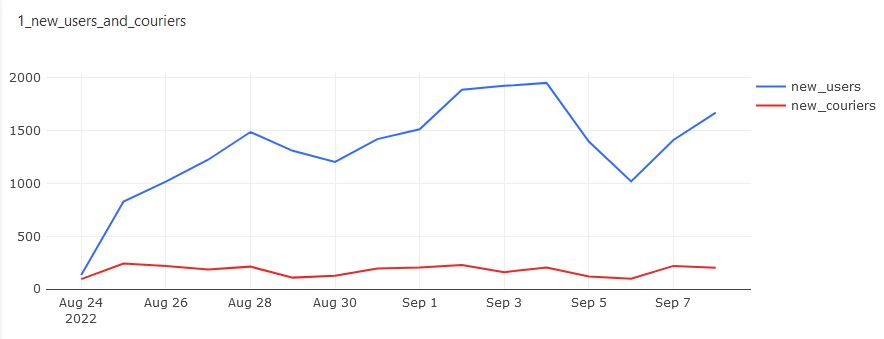

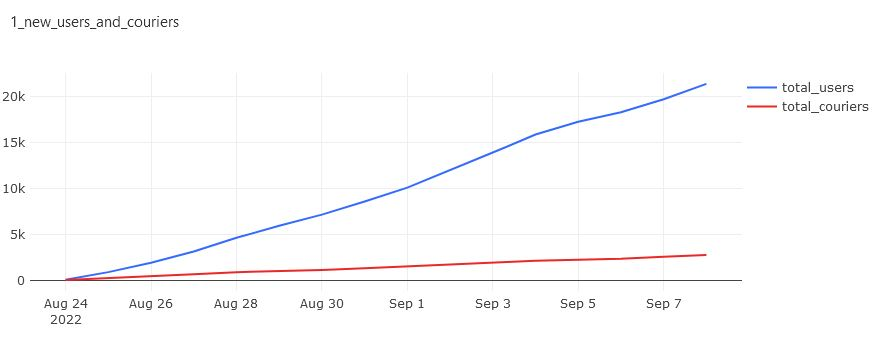

In [ ]:
###

In [ ]:
--2
--определим самую раннюю дату действия каждого пользователя
--из таблицы user_actions
WITH user_first_action AS (
    SELECT
        DATE_TRUNC('day', t.time) AS date
        ,t.user_id
        ,MIN(DATE_TRUNC('day', t.time))
            OVER (PARTITION BY t.user_id) AS start_user_day
    FROM
        user_actions AS t
),
--вычислим количество новых пользователей за каждый день
new_users AS (
    SELECT
        t.start_user_day AS date
        ,COUNT(DISTINCT t.user_id) AS new_users
    FROM
        user_first_action AS t
    GROUP BY
        t.start_user_day
    ORDER BY
        t.start_user_day ASC
    ),
--определим самую раннюю дату действия каждого курьера
--из таблицы courier_actions
courier_first_action AS (
    SELECT
        DATE_TRUNC('day', t.time) AS date
        ,t.courier_id
        ,MIN(DATE_TRUNC('day', t.time))
            OVER (PARTITION BY t.courier_id) AS start_courier_day
    FROM
        courier_actions AS t
),
--вычислим количество новых курьеров за каждый день
new_couriers AS (
    SELECT
        t.start_courier_day AS date
        ,COUNT(DISTINCT t.courier_id) AS new_couriers
    FROM
        courier_first_action AS t
    GROUP BY
        t.start_courier_day
    ORDER BY
        t.start_courier_day ASC
),
--объединяем в одну таблицу сведения о новых клиентах
--и новых курьерах за каждый день
new_users_couriers AS (
    SELECT
        t.date
        ,t.new_users
        ,c.new_couriers
    FROM
        new_users AS t
        LEFT JOIN new_couriers AS c
            ON t.date = c.date
),
--рассчитаем общее число пользователей и курьеров
--на каждый день
total_users_couriers AS (
    SELECT
        t.date::DATE
        ,t.new_users
        ,t.new_couriers
        ,(SUM(t.new_users) OVER w)::INT AS total_users
        ,(SUM(t.new_couriers) OVER w)::INT AS total_couriers
    FROM
        new_users_couriers AS t
    WINDOW w AS (
        ORDER BY t.date
)
ORDER BY
    t.date::DATE
)
--вычислим динамику показателей в относительных величинах
SELECT
    t.date
    ,t.new_users
    ,t.new_couriers
    ,t.total_users
    ,t.total_couriers
    ,ROUND(
        t.new_users * 100. / LAG(t.new_users, 1)
        OVER () - 100, 2) AS new_users_change
    ,ROUND(
        t.new_couriers * 100. / LAG(t.new_couriers, 1)
        OVER () - 100, 2) AS new_couriers_change
    ,ROUND(
        t.total_users * 100. / LAG(t.total_users, 1)
        OVER () - 100, 2) AS total_users_growth
    ,ROUND(
        t.total_couriers * 100. / LAG(t.total_couriers, 1)
        OVER () - 100, 2) AS total_couriers_growth
FROM
    total_users_couriers AS t
ORDER BY
    t.date ASC;

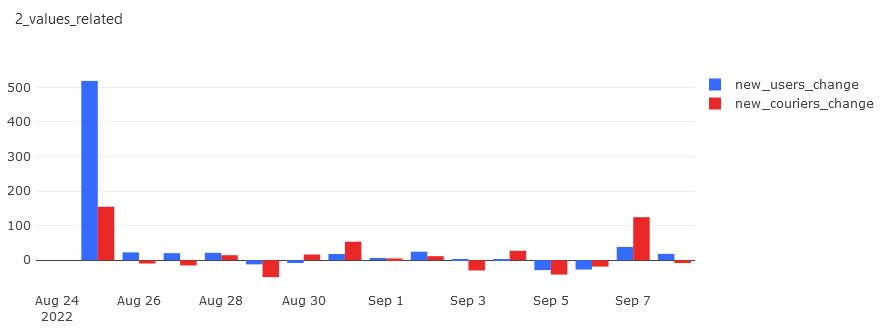

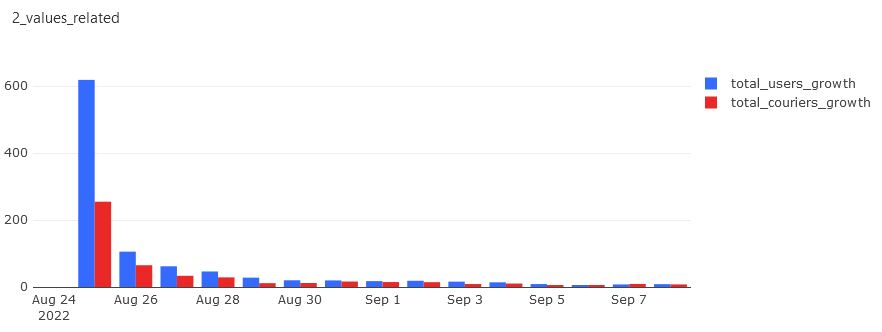

In [ ]:
###

In [ ]:
--3
--определим самую раннюю дату действия каждого пользователя
--из таблицы user_actions
WITH user_first_action AS (
    SELECT
        DATE_TRUNC('day', t.time) AS date
        ,t.user_id
        ,MIN(DATE_TRUNC('day', t.time))
            OVER (PARTITION BY t.user_id) AS start_user_day
    FROM
        user_actions AS t
),
--вычислим количество новых пользователей за каждый день
new_users AS (
    SELECT
        t.start_user_day AS date
        ,COUNT(DISTINCT t.user_id) AS new_users
    FROM
        user_first_action AS t
    GROUP BY
        t.start_user_day
    ORDER BY
        t.start_user_day ASC
    ),
--определим самую раннюю дату действия каждого курьера
--из таблицы courier_actions
courier_first_action AS (
    SELECT
        DATE_TRUNC('day', t.time) AS date
        ,t.courier_id
        ,MIN(DATE_TRUNC('day', t.time))
            OVER (PARTITION BY t.courier_id) AS start_courier_day
    FROM
        courier_actions AS t
),
--вычислим количество новых курьеров за каждый день
new_couriers AS (
    SELECT
        t.start_courier_day AS date
        ,COUNT(DISTINCT t.courier_id) AS new_couriers
    FROM
        courier_first_action AS t
    GROUP BY
        t.start_courier_day
    ORDER BY
        t.start_courier_day ASC
),
--объединяем в одну таблицу сведения о новых клиентах
--и новых курьерах за каждый день
new_users_couriers AS (
    SELECT
        t.date
        ,t.new_users
        ,c.new_couriers
    FROM
        new_users AS t
        LEFT JOIN new_couriers AS c
            ON t.date = c.date
),
--рассчитаем общее число пользователей и курьеров
--на каждый день
total_users_couriers AS (
    SELECT
        t.date::DATE
        ,t.new_users
        ,t.new_couriers
        ,(SUM(t.new_users) OVER w)::INT AS total_users
        ,(SUM(t.new_couriers) OVER w)::INT AS total_couriers
    FROM
        new_users_couriers AS t
    WINDOW w AS (
        ORDER BY t.date
)
ORDER BY
    t.date::DATE
),
--получаем id отмененных заказов
orders_cancel AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--вычислим количество платящих пользователей
--(т.е. оформивших и не отменивших заказ)
paying_users AS (
    SELECT
        t.time::DATE AS date
        ,COUNT(DISTINCT t.user_id) AS paying_users
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_cancel AS t)
    GROUP BY
        t.time::DATE
    ORDER BY
        t.time::DATE ASC
),
--получим id доставленных курьерами заказов
orders_delivered AS (
SELECT
    t.order_id AS order_id_delivered
FROM
    courier_actions AS t
WHERE
    t.action = 'deliver_order'
),
--посчитаем количество активных курьеров
active_couriers AS (
SELECT
    t.time::DATE AS date
    ,COUNT(DISTINCT courier_id) AS active_couriers
FROM
    courier_actions AS t
WHERE
    t.order_id IN (
        SELECT t.order_id_delivered
        FROM orders_delivered AS t)
GROUP BY
    t.time::DATE
ORDER BY
    t.time::DATE
),
--объединим сведения об общем числе пользователей/курьеров,
--платящих пользовтелях и активных курьерах
pivot_table AS (
SELECT
    t.date
    ,t.total_users
    ,t.total_couriers
    ,u.paying_users
    ,c.active_couriers
FROM
    total_users_couriers AS t
    LEFT JOIN paying_users AS u
        ON t.date = u.date
    LEFT JOIN active_couriers AS c
        ON t.date = c.date
ORDER BY
    t.date ASC
)
--вычислим долю платящих пользователей
--в общем числе пользователей текущего дня
--и долю активных курьеров в общем числе курьеров текущего дня
SELECT
    t.date
    ,t.paying_users
    ,t.active_couriers
    ,ROUND(t.paying_users * 100. / t.total_users, 2)
        AS paying_users_share
    ,ROUND(t.active_couriers * 100. / t.total_couriers, 2)
        AS active_couriers_share
FROM
    pivot_table AS t
ORDER BY
    t.date ASC;

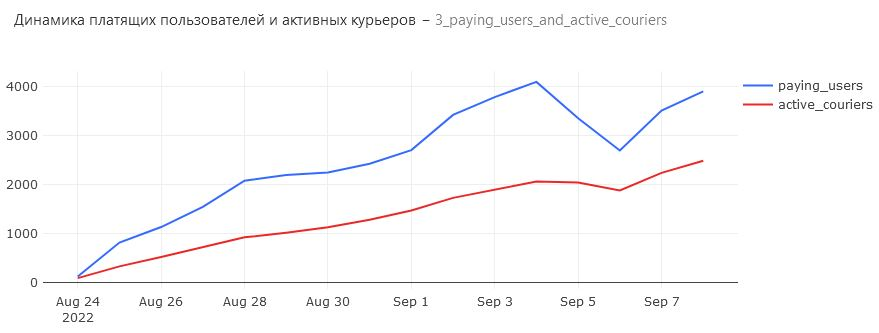

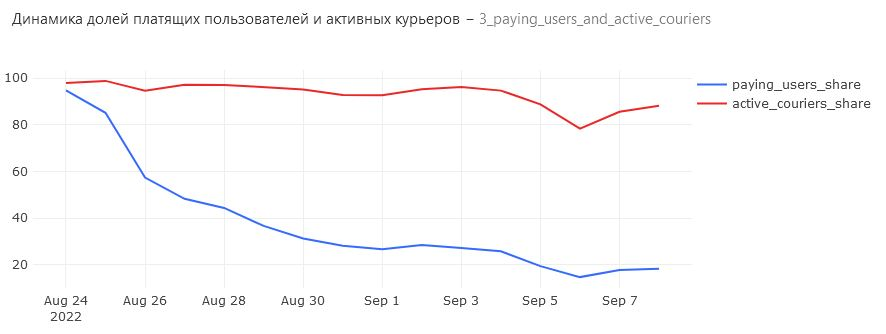

In [ ]:
###

In [ ]:
--4
--получим id заказов, которые были отменены пользователями
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--вычислим количество заказов каждого пользователя
--в каждый отчетный день
orders_count AS (
    SELECT
        t.time::DATE AS date
        ,t.user_id
        ,COUNT(t.order_id) AS orders_count
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    GROUP BY
        t.time::DATE
        ,t.user_id
    ORDER BY
        t.time::DATE ASC
        ,t.user_id ASC
),
--для каждого отчетного дня вычислим количество пользователей,
--сделавших один заказ в отчетный день
--и более одного заказа в отчетный день
single_several_orders AS (
    SELECT
        t.date
        ,COUNT(t.user_id) FILTER (WHERE t.orders_count = 1)
            AS single_order_users
        ,COUNT(t.user_id) FILTER (WHERE t.orders_count > 1)
            AS several_order_users
        ,COUNT(t.user_id) AS total_users
    FROM
        orders_count AS t
    GROUP BY
        t.date
)
--вычислим долю пользователей, сделавших один заказ в день,
--долю пользователей, сделавших два и более заказа в день,
--в общем количестве платящих пользователей
SELECT
    t.date
    ,ROUND(t.single_order_users * 100. / t.total_users, 2)
        AS single_order_users_share
    ,ROUND(t.several_order_users * 100. / t.total_users, 2)
        AS several_orders_users_share
FROM
    single_several_orders AS t
ORDER BY
    t.date ASC;

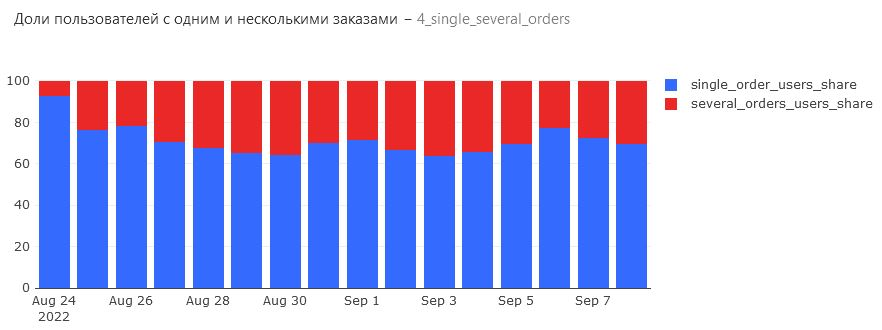

In [ ]:
###

In [ ]:
--5
--получим id отмененных заказов
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--посчитаем общее число заказов по каждому дню
total_orders_per_day AS (
    SELECT
        t.time::DATE as date
        ,COUNT(DISTINCT t.order_id)::INT AS orders
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    GROUP BY
        t.time::DATE
),
--для каждого дня вычислим самые ранние
--дату и время оформления первого неотмененного заказа
first_order_time AS (
    SELECT
        t.time::DATE AS date
        ,t.user_id
        ,t.order_id
        ,MIN(t.time) OVER (PARTITION BY t.user_id) AS first_order_time
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    ORDER BY
        t.time::DATE ASC
),
--для каждого дня посчитаем число первых заказов
--(заказов, сделанных пользователем впервые)
first_order_numbers AS (
    SELECT
        t.first_order_time::DATE AS date
        ,COUNT(DISTINCT t.user_id)::INT AS first_orders
    FROM
        first_order_time AS t
    GROUP BY
        t.first_order_time::DATE
    ORDER BY
        1 ASC
),
--для каждого пользователя получим самую раннюю дату
--совершения заказа
first_order_day AS (
    SELECT
        DISTINCT t.user_id
        ,MIN(t.time::DATE) OVER (PARTITION BY t.user_id) AS first_user_day
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
        AND t.action = 'create_order'
    ORDER BY
        t.user_id ASC
),
--посчитаем общее число заказов каждого пользователя на каждую дату
total_user_orders_per_day AS (
SELECT
    t.time::DATE AS date
    ,t.user_id
    ,COUNT(t.order_id) AS count_orders
FROM
    user_actions AS t
WHERE
    t.order_id NOT IN (
        SELECT t.order_id_canceled
        FROM orders_canceled AS t)
    AND t.action = 'create_order'
GROUP BY
    t.time::DATE
    ,t.user_id
ORDER BY
    t.time::DATE ASC
    ,t.user_id ASC
),
--для каждого дня первой активности пользователя
--добавим сведения о числе сделанных в первый день заказов
orders_in_first_day AS (
SELECT
    t.first_user_day AS date
    ,t.user_id
    ,COALESCE(u.count_orders, 0) AS count_orders
FROM
    first_order_day AS t
    INNER JOIN total_user_orders_per_day AS u
        ON t.user_id = u.user_id
            AND t.first_user_day = u.date
),
--вычислим число заказов, сделанных пользователями в тот же день,
--когда они впервые воспользовались сервисом
count_new_users_orders AS (
SELECT
    t.date
    ,SUM(t.count_orders)::INT AS new_users_orders
FROM
    orders_in_first_day AS t
GROUP BY
    t.date
ORDER BY
    t.date ASC
)
--объединим сведения об общем числе заказов,
--числе первых заказов пользователей,
--числе заказов новых пользователей в первый день пользования сервисом,
--а также вычислим долю первых заказов в общем числе заказов
--и долю заказов новых пользователей в общем числе заказов
SELECT
    t.date
    ,t.orders
    ,f.first_orders
    ,c.new_users_orders
    ,ROUND(f.first_orders * 100. / t.orders, 2)
        AS first_orders_share
    ,ROUND(c.new_users_orders * 100. / t.orders, 2)
        AS new_users_orders_share
FROM
    total_orders_per_day AS t
    LEFT JOIN first_order_numbers AS f
        ON t.date = f.date
    LEFT JOIN count_new_users_orders AS c
        ON t.date = c.date
ORDER BY
    t.date ASC;

In [ ]:
--вычислим число заказов, сделанных каждым пользователем
--в первый день пользования сервисом
first_day_number_orders AS (
SELECT
    t.date
    ,t.user_id
    ,COUNT(t.order_id) AS count_orders
FROM
    first_order_day AS t
WHERE
    t.date = t.first_user_day
GROUP BY
    t.date
    ,t.user_id
HAVING
    COUNT(t.order_id) > 0
)
--посчитаем для каждого дня число заказов,
--сделанных пользователями в первый день пользования сервисом
SELECT
    t.date
    ,SUM(t.count_orders) AS new_users_orders
FROM
    first_day_number_orders AS t
GROUP BY
    t.date
HAVING
    SUM(t.count_orders) > 0
ORDER BY
    t.date ASC

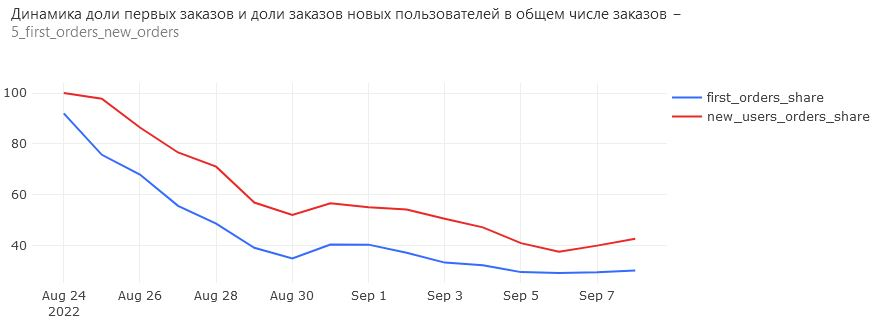

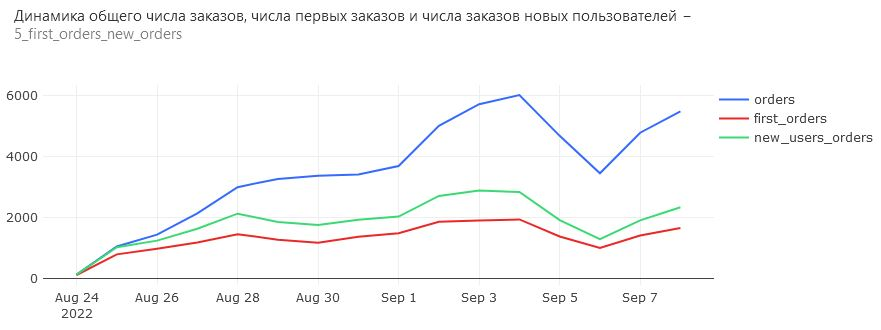

In [ ]:
###

In [ ]:
--6
--получим id заказов, которые были отменены
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--получим id заказов, которые были доставлены
orders_delivered AS (
    SELECT
        t.order_id AS order_id_deliver
    FROM
        courier_actions AS t
    WHERE
        t.action = 'deliver_order'
),
--за каждый отчетный день вычислим число заказов,
--которые не были отменены и были успешно доставлены
total_orders_per_day AS (
    SELECT
        t.creation_time::DATE AS date
        ,COUNT(t.order_id) AS total_orders
    FROM
        orders AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
        AND t.order_id IN (
            SELECT t.order_id_deliver
            FROM orders_delivered AS t)
    GROUP BY
        t.creation_time::DATE
    ORDER BY
        t.creation_time::DATE ASC
),
--за каждый день посчитаем число платящих клиентов
--(которые в отчетный день оформили хотя бы один неотмененный заказ)
paying_users AS (
    SELECT
        t.time::DATE AS date
        ,COUNT(DISTINCT t.user_id) AS user_paying_per_day
    FROM
        user_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    GROUP BY
        t.time::DATE
    ORDER BY
        t.time::DATE
),
--за каждый день посчитаем число активных курьеров,
--которые приняли хотя бы один заказ или доставили хотя бы один заказ
active_couriers AS (
    SELECT
        t.time::DATE AS date
        ,COUNT(DISTINCT t.courier_id) AS courier_active_per_day
    FROM
        courier_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
    GROUP BY
        t.time::DATE
    ORDER BY
        t.time::DATE
),
--объединим сведения о числе заказов, платящих пользователях
--и активных курьерах
--(как вариант вместо pivot_table на лету можно
--посчитать необходимые доли, пропустив саму сводную таблицу;
--в запросе сводная таблица оставлена для наглядности)
pivot_table AS (
    SELECT
        t.date
        ,t.total_orders
        ,p.user_paying_per_day
        ,a.courier_active_per_day
    FROM
        total_orders_per_day AS t
        LEFT JOIN paying_users AS p
            ON t.date = p.date
        LEFT JOIN active_couriers AS a
            ON t.date = a.date
    ORDER BY
        t.date ASC
)
--вычислим число платящих пользователей на одного активного курьера
--и число заказов на одного активного курьера
SELECT
    t.date
    ,ROUND(t.user_paying_per_day * 1. / t.courier_active_per_day, 2)
        AS users_per_courier
    ,ROUND(t.total_orders * 1. / t.courier_active_per_day, 2)
        AS orders_per_courier
FROM
    pivot_table AS t
ORDER BY
    t.date ASC;

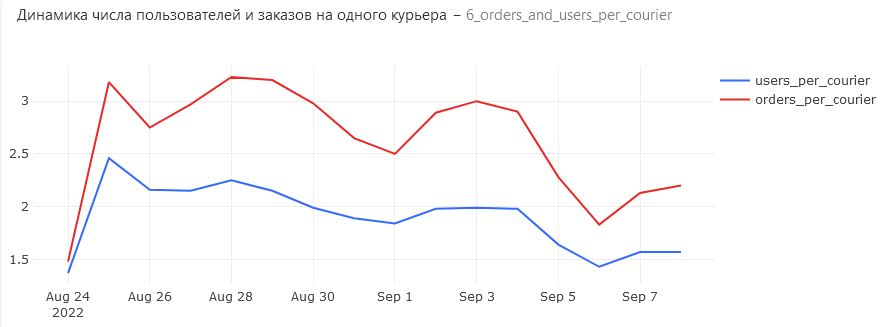

In [ ]:
###

In [ ]:
--7
--получим id заказов, которые были отменены
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--получим id заказов, которые были доставлены
orders_delivered AS (
    SELECT
        t.order_id AS order_id_deliver
    FROM
        courier_actions AS t
    WHERE
        t.action = 'deliver_order'
),
--получим сведения о дате и времени принятия и доставки
--каждого неотмененного доставленного заказа
accept_deliver_order AS (
    SELECT
        DISTINCT t.time::DATE AS date
        ,t.order_id
        ,MIN(t.time) OVER (PARTITION BY t.order_id)
            AS accept_time
        ,MAX(t.time) OVER (PARTITION BY t.order_id)
            AS deliver_time
    FROM
        courier_actions AS t
    WHERE
        t.order_id NOT IN (
            SELECT t.order_id_canceled
            FROM orders_canceled AS t)
        AND t.order_id IN (
            SELECT t.order_id_deliver
            FROM orders_delivered AS t)
    ORDER BY
        t.time::DATE ASC
        ,t.order_id ASC
)
--посчитаем количество минут, которое потребовалось на доставку
--каждого заказа
SELECT
    t.date
    ,ROUND(
        AVG(EXTRACT(EPOCH FROM t.deliver_time - t.accept_time) / 60)
        )::INT
        AS minutes_to_deliver
FROM
    accept_deliver_order AS t
GROUP BY
    t.date;

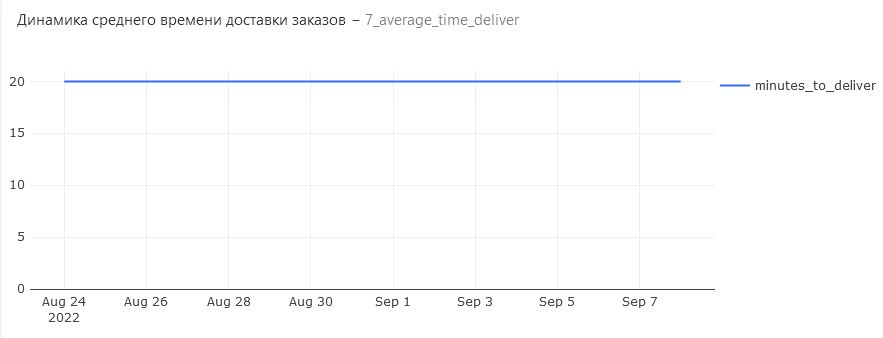

In [ ]:
###

In [ ]:
--8
--получим id отмененных заказов
WITH orders_canceled AS (
    SELECT
        t.order_id AS order_id_canceled
    FROM
        user_actions AS t
    WHERE
        t.action = 'cancel_order'
),
--получим id успешно доставленных заказов
orders_deliver AS (
    SELECT
        t.order_id AS order_id_deliver
    FROM
        courier_actions AS t
    WHERE
        t.action = 'deliver_order'
),
--проверим, являются ли все order_id в таблице orders уникальными
uniqueness_checking AS (
    SELECT
        COUNT(t.order_id)
        ,COUNT(DISTINCT t.order_id)
    FROM
        orders AS t
),
--присвоим каждому заказу индекс 0 или 1
--(успешно доставлен: 1, иначе 0)
--(отменен: 1, иначе 0)
successed_canceled_orders AS (
    SELECT
        EXTRACT(HOUR FROM t.creation_time)::INT AS hour
        ,CASE
            WHEN t.order_id IN (
                SELECT t.order_id_deliver
                FROM orders_deliver AS t) THEN 1
            ELSE 0
            END AS successful_orders
        ,CASE
            WHEN t.order_id IN (
                SELECT t.order_id_canceled
                FROM orders_canceled AS t) THEN 1
            ELSE 0
            END AS canceled_orders
    FROM
        orders AS t
)
--вычислим количество успешно доставленных и отмененных заказов
--по каждому часу,
--а также долю отмененных заказов в общем числе заказов
SELECT
    t.hour
    ,SUM(t.successful_orders) AS successful_orders
    ,SUM(t.canceled_orders) AS canceled_orders
    ,ROUND(SUM(t.canceled_orders) * 1. / (
        SUM(t.canceled_orders) + SUM(t.successful_orders)
        ), 3) AS cancel_rate
FROM
    successed_canceled_orders AS t
GROUP BY
    t.hour
ORDER BY
    t.hour ASC;

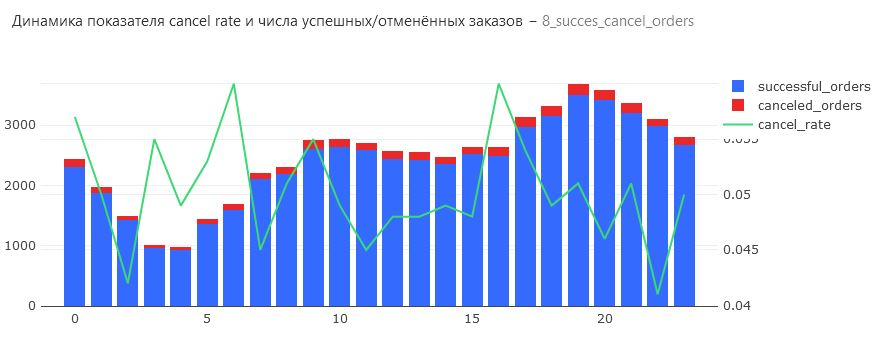